In [1]:
%reset -f
import warnings
warnings.filterwarnings('ignore')
from helpers import *
%matplotlib inline

# TLDR: Deep Learning performs impressive cell segmentation

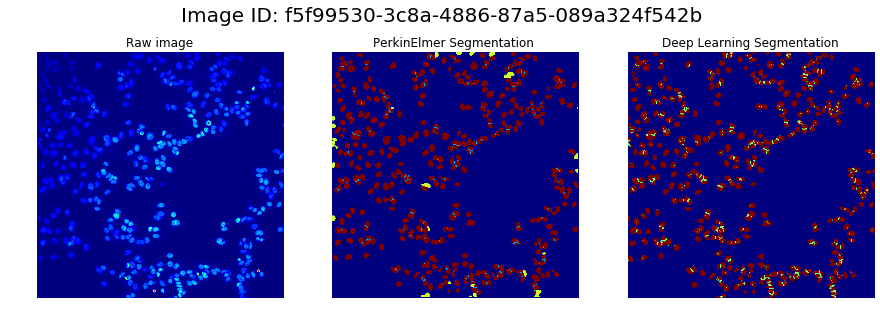

In [2]:
np.random.seed(42)
seg = Segmenter('oldmodels/patches31-ep97-lr0.001', np.random.choice(image_IDs))
seg.display()

# Cell Segmentation

Cell segmentation is the task of identifying seperate cell nuclei in a cellular assay. Due to varying pixel intensities and cell nuclei clumping together, it is hard to achieve near perfect accuracy on this problem. PerkinElmer is a biotechnology company which sells cell segmentation software. Using a combination of segmentation techniques that use pixel thresholding and the watershed algorithm, they have annotated 3024 cell assays with the nuclei of each cell. The company is able to successfully segment a large proportion of cells in each assay. However, there are areas where their algorithm performs poorly, which they discard. These are shown below.

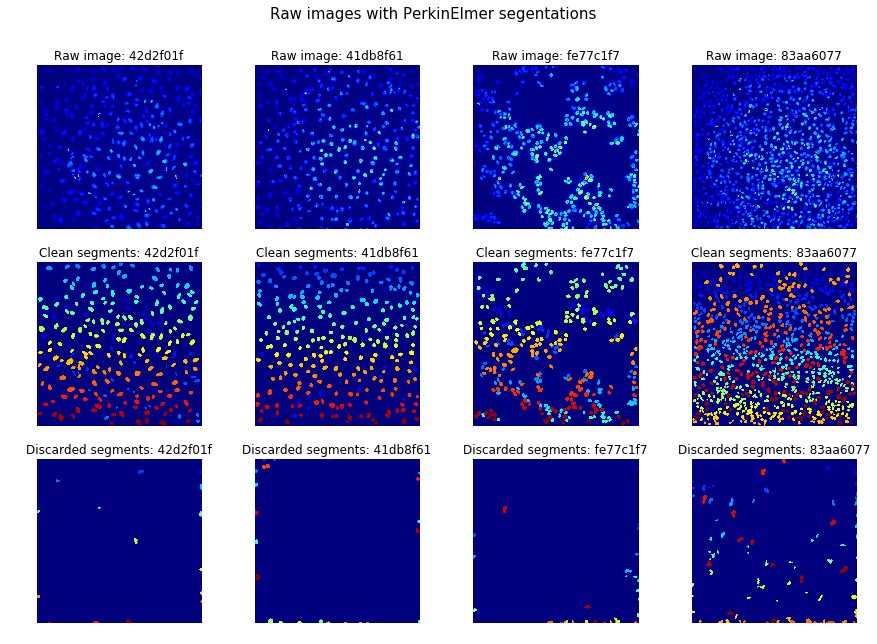

In [3]:
display_example_segmentations()

Drawing inspiration from [DeepCell](https://www.ncbi.nlm.nih.gov/pubmed/27814364), a recently published method (November 2016) in PLOS genetics, we investigated whether deep learning could automate this process using labels provided to us from PerkinElmer. Our strategy was to train a classifier to classify a pixel as being within a nucleus or part of the background, using a square neighbourhood around the pixel.

We noticed that the areas where the existing algorithm performed the most poorly were in areas that were between cells, and in the outer regions of the image. To address the first source to error, we decided to include an additional pixel class which indicated whether a pixel was between two or more cells. We generated training data for this class by looking at the clean segments, and tested whether there existed more than one cleanly labelled cell in a 5x5 radius. We used this to generate a single image which included background, between cell, cleanly segmented, discarded regions. The dark blue signifies background regions, yellow signifies discarded regions, light blue signifies between cells regions and red signifed cleanly segmented cell regions.

We expect that the poor performance in the outer regions was due to the on average lower pixel intensities. 

# Display training data

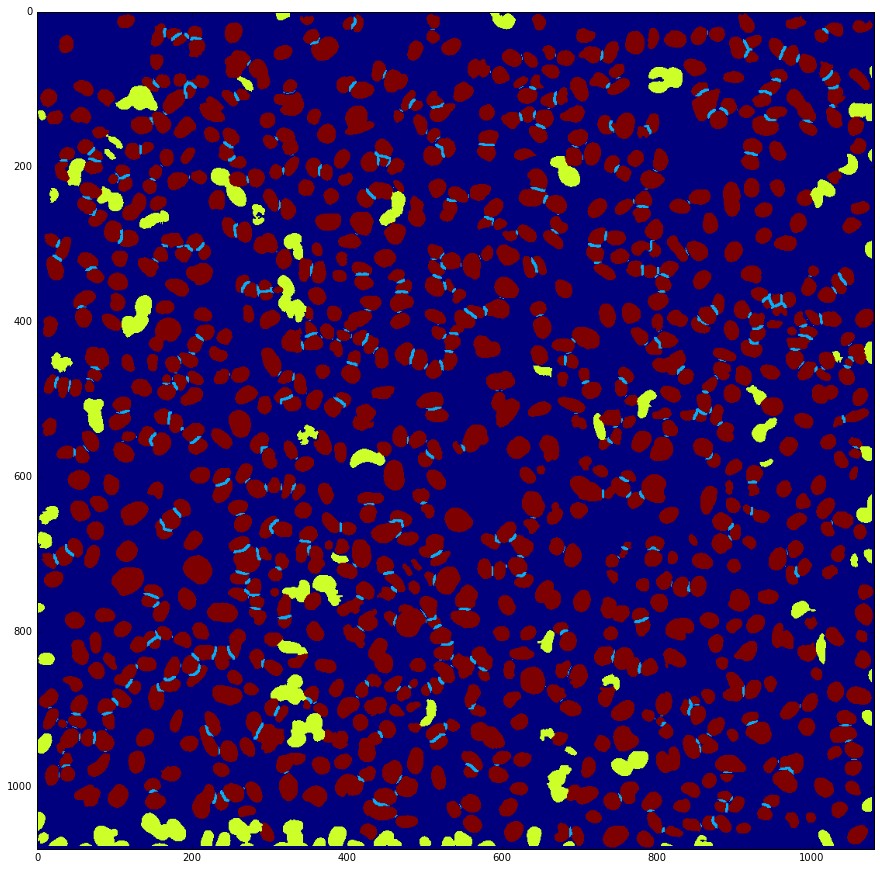

In [4]:
display_random_border_image()

# Generating Training Data

Since by definition the discarded regions are the regions where the PerkinElmer segmenter performs poorly, we did not want to include these pixels in our classifier. Furthermore, we *did not want to include any pixel who's neighbour was in a discard region*. Our training data consisted of 11x11 pixel patches of the image which were chosen such that did not overlap with any region that was discarded. To ensure balanced classes, we sample from each class the amount that was equal to the class with the lowest number of pixels. Invariably, this was the between pixel class.

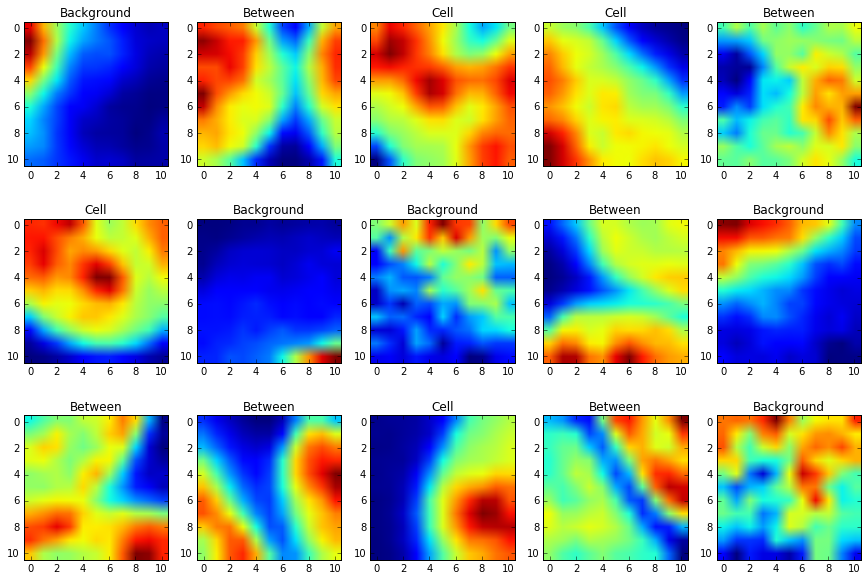

In [5]:
patches = pickle.load(open('patches/oldpatches/patches_51.py','rb'))
display_random_patches(patches)

# Training a classifier

We then trained a convolutional neural network with 3 convolutional layers and 2 fully connected layers. These convolutional layers had 128, 128 and 64 filters, and filter sizes of 5x5, 5x5, and 3x3 respectively. The fully connected layers both had 1000 hidden units. We included dropout with keep probability equal to 0.5 after each layer to prevent overfitting. This architecture is similar to the architecture commonly use on the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

In [6]:
clf = Classifier(params = {'epochs':20,'display_step':1,'batch_size':500,'learning_rate': 0.001,'patches_number': 31,'models_dir': 'models/'})
clf.train()

Ep: 0, train c: 19.4, train acc: 0.910, test c: 138.0,  test acc: 0.906, secs p/e 49.9914348125, 4602.3 imgs p/s
Ep: 1, train c: 18.3, train acc: 0.897, test c: 94.6,  test acc: 0.932, secs p/e 49.8102419376, 4619.1 imgs p/s
Ep: 2, train c: 17.6, train acc: 0.910, test c: 81.7,  test acc: 0.950, secs p/e 49.7162029743, 4627.8 imgs p/s
Ep: 3, train c: 15.6, train acc: 0.923, test c: 86.1,  test acc: 0.936, secs p/e 49.7267091274, 4626.8 imgs p/s
Ep: 4, train c: 18.9, train acc: 0.885, test c: 75.8,  test acc: 0.958, secs p/e 49.6411340237, 4634.8 imgs p/s
Ep: 5, train c: 16.2, train acc: 0.923, test c: 78.5,  test acc: 0.930, secs p/e 49.6738479137, 4631.8 imgs p/s
Ep: 6, train c: 18.6, train acc: 0.910, test c: 92.0,  test acc: 0.934, secs p/e 49.6316840649, 4635.7 imgs p/s
Ep: 7, train c: 18.2, train acc: 0.897, test c: 89.3,  test acc: 0.940, secs p/e 49.6700820923, 4632.1 imgs p/s
Ep: 8, train c: 18.3, train acc: 0.910, test c: 89.4,  test acc: 0.942, secs p/e 49.5803658962, 4640.5 

# Segmenting the Image

Image Segmentation can be reduced to a classification task. Given a new image, each pixel along with it's 11x11 neighbourhood patch is fed into our deep model. Each pixel is then given a class based on the output of the model of: background, between cell and within cell. Once these classes have been attributed, the task of cell segmentation reduces to choosing all the pixels of a specific class.

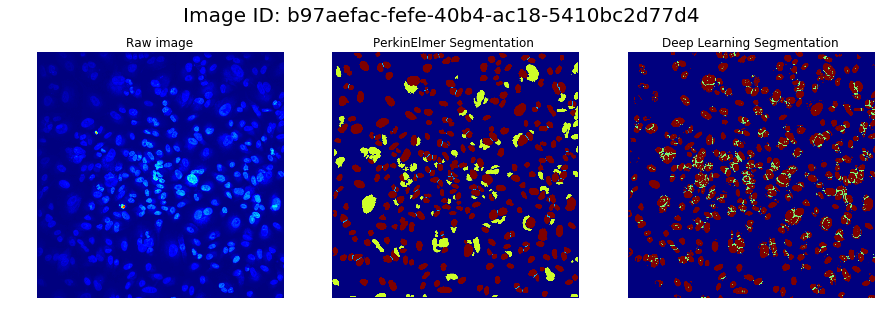

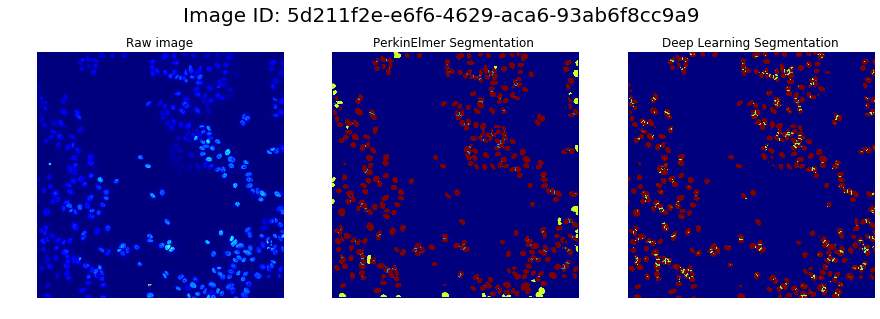

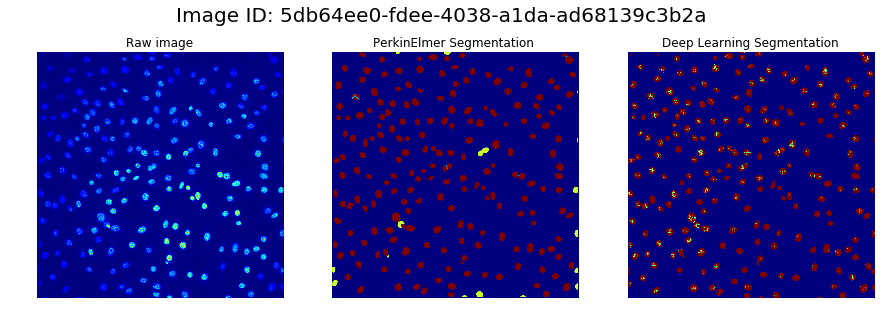

In [7]:
for ID in np.random.choice(image_IDs, 3):    
    seg = Segmenter('oldmodels/patches31-ep97-lr0.001', ID)
    seg.display()

# Conclusion: Deep learning performs impressive cell segmentation

We see that deep learning performs better cell segmentation on discarded regiond that the segmenter the PerkinElmer provided for us. Our model seems to over classfiy areas of between cells. This could be because we provided all three classes in equal measure to the model, when in fact the between cell class is heavily under-represented in the raw data.

This provides the exciting possibility of automatic cell annotation using similar methods, should such training data be made available to us. 